In [2]:
!pip install sam2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
  Created wheel for sam2: filename=sam2-0.4.1-cp310-cp310-linux_x86_64.whl size=447415 sha256=796fb784ecf940af6cb880c7bb733975dcffc7508946fb95f432ee0a929b4921
  Stored in directory: /root/.cache/pip/wheels/f7/24/19/6ae406a45571a7fed8ef81297fc11698486638ac21200cdafa
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=

In [3]:
import rasterio
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import argparse
import os
import cv2
import time
 
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from segment_anything import sam_model_registry, SamPredictor

/opt/conda/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [4]:
file_path = '/kaggle/input/forestfire-russia/train2/0.tiff'

In [5]:
def print_geotiff_info(path):
    try:
        with rasterio.open(path) as src:
            # Основные метаданные
            print(f"File Path: {path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            # Информация по каждому каналу
            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")

    except Exception as e:
        print(f'Error: {e}')

In [6]:
# Вывод информации о GeoTIFF
print_geotiff_info(file_path)

File Path: /kaggle/input/forestfire-russia/train2/0.tiff
Driver: GTiff
Width: 215
Height: 222
Count (Bands): 5
CRS: EPSG:4326
Transform: | 10.00, 0.00, 71.47|
| 0.00,-10.00, 56.30|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=71.474895, bottom=-2163.700927, right=2221.474895, top=56.299073)
Datum: ('float32', 'float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 4.0
  Max Value: 23.0
  Mean Value: 12.358684539794922
  Standard Deviation: 3.08229660987854

Band 2:
  Data Type: float32
  Min Value: 5.0
  Max Value: 30.0
  Mean Value: 15.506264686584473
  Standard Deviation: 4.18515682220459

Band 3:
  Data Type: float32
  Min Value: 4.0
  Max Value: 41.0
  Mean Value: 18.802011489868164
  Standard Deviation: 6.582454204559326

Band 4:
  Data Type: float32
  Min Value: 4.0
  Max Value: 76.0
  Mean Value: 34.52409362792969
  Standard Deviation: 11.44923210144043

Band 5:
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean Value: 0.1326628923

In [7]:
def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            #photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            #photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
    except Exception as e:
        print(f'Ошибка: {e}')

Number of bands: 5


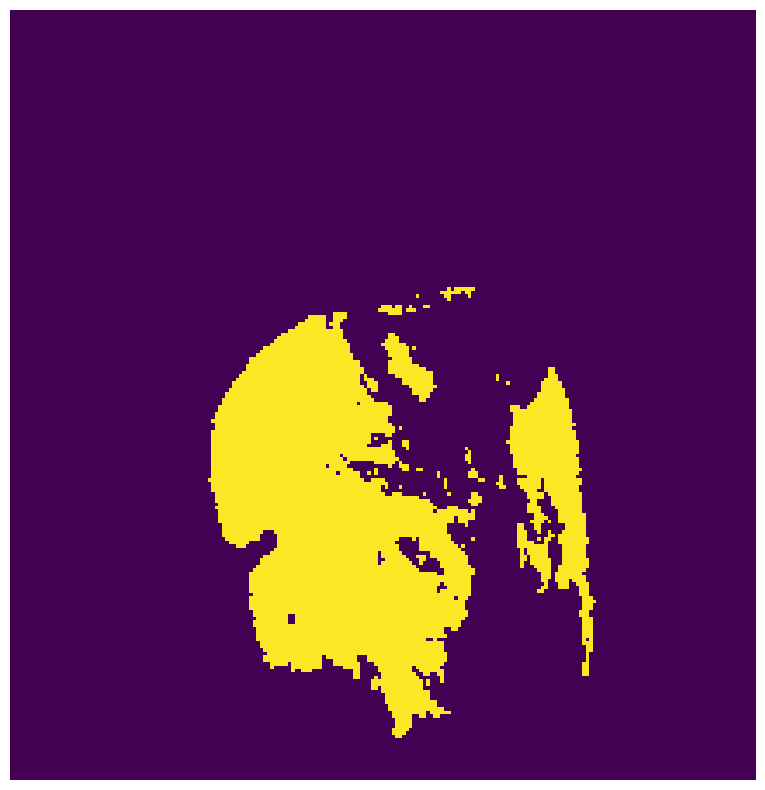

In [8]:
# Визуализация изображения
visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5)

In [9]:
df = pd.read_csv("/kaggle/input/forestfire-russia/train/00/2021-06-06_weather.csv")
df.head()

,Дата,Тсред,Тмин,Тмакс,Осадки всего,Направление ветра,Скорость ветра,Порывы ветра,Атмосферное Давление
0,2021-03-18,-5.8,-7.7,-3.6,0.0,240.0,17.5,NaN,1030.0
1,2021-03-19,-5.9,-8.5,-2.5,0.0,172.0,27.3,NaN,1023.4
2,2021-03-20,-2.2,-5.1,1.0,1.7,178.0,24.9,NaN,1002.3
3,2021-03-21,-0.8,-2.7,0.2,0.6,246.0,26.5,NaN,999.7
4,2021-03-22,-2.1,-4.0,0.0,1.0,223.0,11.6,NaN,1010.8


In [10]:
def load_sam_model(model_type="vit_b"):
    sam = sam_model_registry[model_type](checkpoint='/kaggle/input/weights-b/sam_vit_b_01ec64.pth')
    sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
    print("suck sess model")
    return sam

def get_sam_predictor(model):
    predictor = SamPredictor(model)
    print("suck sess predictor")
    return predictor


In [11]:
def segment_image_with_sam(file_path, predictor, band_indices=(1, 2, 3)):
    try:
        with rasterio.open(file_path) as src:
            r_band, g_band, b_band = band_indices
            red = src.read(r_band)
            green = src.read(g_band)
            blue = src.read(b_band)

            # собираем lgbt каналы
            rgb_image = np.stack([red, green, blue], axis=-1).astype(np.uint8)

            predictor.set_image(rgb_image)

            masks, scores, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=True)

            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(rgb_image)
            for mask in masks:
                ax.imshow(mask, cmap='jet', alpha=0.5)  # Наложение масок на изображение
            ax.axis('off')
            plt.show()

    except Exception as e:
        print(f"Ошибка при сегментации: {e}")

suck sess model
suck sess predictor


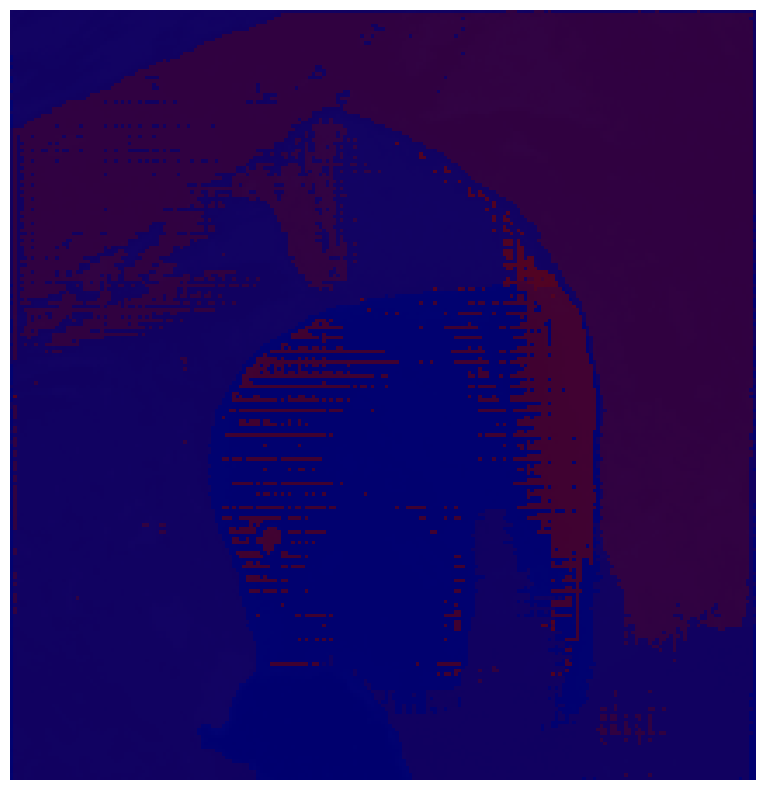

In [13]:
file_path = '/kaggle/input/forestfire-russia/train2/0.tiff'
model_path = '/your/path/to/sam_vit_h_4b8939.pth'


model = load_sam_model()

predictor = get_sam_predictor(model)

segment_image_with_sam(file_path, predictor)